In [165]:
#This Notebook presents a code to do a decompositon onto Alfven Slow and Fast modes
#Darryl Seligman version1 9/11/18
#Adapted from version of code by Jonathan Squire
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import *
def mode_decomp(Vx,Vy,Vz,beta):
    #Form grid of K
    n=Vx.shape[0]
    
    N=[n,n,n]
    L=[1.,1.,1.]
    if(n%2==0):
        b=np.arange(0,N[0]/2)
        bb = np.linspace(-N[0]/2.,-1,N[0]/2)
    else:
        print "hello"
        b=np.arange(0,N[0]/2)
        bb = np.linspace(-N[0]/2.,-1.5,N[0]/2)
        bb=np.append(bb,[.5])
    #Form k-space vectors for each dimension [0 1 2 3 ... N/2-1 -N/2 -N/2+1 ... -2 -1]*2*pi/L
    
    kx=  2*np.pi*1j/L[0]*np.concatenate((b,bb))
    ky=  2*np.pi*1j/L[1]*np.concatenate((b,bb))
    kz=  2*np.pi*1j/L[2]*np.concatenate((b,bb))
    print kx.shape
    xg=np.linspace(0.,1.,n)
    yg=np.linspace(0.,1.,n)
    zg=np.linspace(0.,1.,n)
    x,y,az=np.meshgrid(xg,yg,zg,indexing='ij')
    #3D arrays of k-space grid
    KX,KY,KZ= np.meshgrid(kx,ky,kz,indexing='ij')
    #grid of |K|, kperp (B0 is in x direction) and k_hat
    Kmag = np.sqrt(abs(KX**2+KY**2+KZ**2))
    Kperp = np.sqrt(abs(KY**2+KZ**2))
    Kmag[0]=1.
    khx = KX/Kmag;
    khy = KY/Kmag;
    khz = KZ/Kmag;
    #k-Grid for binning the spectra
    kgrid = np.arange(0,max(ky.imag)+2.*np.pi/L[0],2.*np.pi/L[0])

    kgridG = (kgrid[0:kgrid.size-1] +  kgrid[1:kgrid.size])/2;   
    #Get B and V, take fourier transforms  
    fVx = fftn(Vx);
    fVy = fftn(Vy); 
    fVz = fftn(Vz);
    # % Alfvenic part -- part of B and u in k*b_hat direction                                                                                                                                                                      
    #% b_hat is x direction 
    kcbhx = 0;
    kcbhy = (khz);
    kcbhz =  - (khy);
    #Alfvenic part of V, (k*bh).V 
    alfV =  kcbhy*fVy + kcbhz*fVz;
    #Compressive part of V   
    cmpVx = fVx;
    cmpVy = fVy + kcbhy*alfV;
    cmpVz = fVz + kcbhz*alfV;
    #% Now decompose compressive part into fast and slow                                                                                                                                                                          
    #% I think this is right, but never actually used this seriously  
    costh = abs(khx);
    sinth = np.sqrt(1.-costh**2);
    #thx = -sinth*np.sign(KX);
    thx = sinth*khx;
    Kperp[Kperp==0]=1.;
    thy = -costh*(KY/Kperp);
    thz = -costh*(KZ/Kperp);
    #% Slow wave part  
    
    slowV = -thx*fVx - thy*fVy - thz*fVz + costh*sinth/beta*(khx*fVx + khy*fVy + khz*fVz);
    thetapart = -thx*fVx - thy*fVy - thz*fVz
    khatpart = khx*fVx + khy*fVy + khz*fVz
    #% Fast wave part  
    fastV = costh*sinth/beta*(thx*fVx + thy*fVy + thz*fVz) + khx*fVx + khy*fVy + khz*fVz;
    
    alfVIso = spect1D((alfV),Kmag,kgrid)
    VIso = spect1D(fVx,Kmag,kgrid) + spect1D(fVy,Kmag,kgrid) + spect1D(fVz,Kmag,kgrid); #% velocity spectrum
    SpFIso =spect1D(cmpVx,Kmag,kgrid) + spect1D(cmpVy,Kmag,kgrid) + spect1D(cmpVz,Kmag,kgrid); #% Compressive part (slow+fast) of the velocity
    slowVIso = spect1D((slowV),Kmag,kgrid); #% Slow mode part
    fastVIso = spect1D((fastV),Kmag,kgrid); #% Fast mode part
    #VIso1 = spect1D((thetapart),Kmag,kgrid)
    #VIso2 = spect1D((khatpart),Kmag,kgrid)
    return(kgridG,alfVIso,fastVIso,slowVIso)#,VIso1,VIso2)
def spect1D(v1,K,kgrid):
    # % Function to find the spectrum <v1^2>,
    #% K is the kgrid associated with v1
    #% kgrid is the grid for spectral shell binning
    nk = len(kgrid)-1;
    print nk
    out1 = np.zeros((nk))
    NT2 = K.size**2;
    for kk in np.arange(nk):

        out1[kk]= np.sum(abs(v1[(K<kgrid[kk+1]) & (K>kgrid[kk])])**2 )/NT2;

    return out1   

[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.  29.
  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.  43.  44.
  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.  56.  57.  58.  59.
  60.  61.  62.  63. -64. -63. -62. -61. -60. -59. -58. -57. -56. -55. -54.
 -53. -52. -51. -50. -49. -48. -47. -46. -45. -44. -43. -42. -41. -40. -39.
 -38. -37. -36. -35. -34. -33. -32. -31. -30. -29. -28. -27. -26. -25. -24.
 -23. -22. -21. -20. -19. -18. -17. -16. -15. -14. -13. -12. -11. -10.  -9.
  -8.  -7.  -6.  -5.  -4.  -3.  -2.  -1.]
(128,)
(128,)
(128, 128, 128)
(128, 128, 128)
(128, 128, 128)
(128, 128, 128)
63
63
63
63
63
63
63
63
63


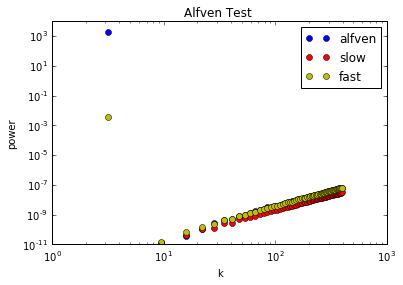

In [13]:
#Test for a linear purely Alfvenic Mode
beta=128;
n=128
xg=np.linspace(0.,1.,n)
yg=np.linspace(0.,1.,n)
zg=np.linspace(0.,1.,n)
x,y,z=np.meshgrid(xg,yg,zg,indexing='ij')
Vx = np.zeros((n,n,n))
Vz = np.zeros((n,n,n))+.01*np.random.rand(n,n,n)
Vy = 10.1*np.sin(2.*128.*np.pi*z)

kgridG,alfVIso,fastVIso,slowVIso=mode_decomp(Vx,Vy,Vz,beta)
plt.loglog(kgridG,alfVIso,'bo',label='alfven')
plt.loglog(kgridG,slowVIso,'ro',label='slow')
plt.loglog(kgridG,fastVIso,'yo',label='fast')
plt.legend()
plt.xlabel('k')
plt.ylabel('power')
plt.title('Alfven Test ')

7.10668695667
0.703562719237
(128,)
63
63
63
63
63
63
63
63
63


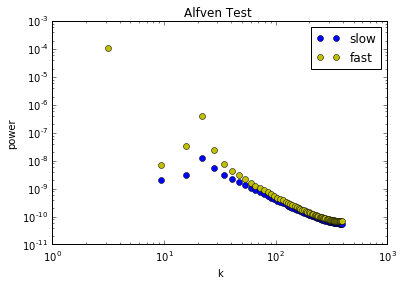

In [168]:
#now test a slow mode
beta=1.e2;
#units alfven speed = 1
va = 1.
cs=np.sqrt(beta/2.)
n=128
B0=1.
A=.001
NN = 4.
costheta=1./np.sqrt(2.)
vplus =np.sqrt(.5*(va**2+cs**2+np.sqrt((va**2+cs**2)**2-4.*va**2*cs**2*costheta**2)))
vminus = np.sqrt(.5*(va**2+cs**2-np.sqrt((va**2+cs**2)**2-4.*va**2*cs**2*costheta**2)))
print vplus
print vminus
#omegaminus = NN*2.*np.pi*(1.+np.sqrt(2.)/2.)**(.5)#*.1
omega = NN*2.*np.pi*vminus
xg=np.linspace(0.,1.,n)
yg=np.linspace(0.,1.,n)
zg=np.linspace(0.,1.,n)
x,y,z=np.meshgrid(xg,yg,zg,indexing='ij')
Vy = np.zeros((n,n,n))
#Vz = np.zeros((n,n,n))+.01*np.random.rand(n,n,n)
#Vy = 10.1*np.sin(2.*128.*np.pi*z)
xpart=.2
zpart=np.sqrt(1.-xpart**2)

Vx = np.sqrt(2.)/(2.*np.pi)/B0*omega*A*np.cos(2.*NN*np.pi/np.sqrt(2.)*(xpart*x+zpart*z))/NN
Vz = A*np.cos(2.*NN*np.pi/np.sqrt(2.)*(xpart*x+zpart*z))
#Vz=
kgridG,alfVIso,fastVIso,slowVIso=mode_decomp(Vz,Vy,Vx,beta)

#plt.loglog(kgridG,alfVIso,'bo',label='alfven')
plt.loglog(kgridG,slowVIso,'bo',label='slow')
plt.loglog(kgridG,fastVIso,'yo',label='fast')
plt.legend()
plt.xlabel('k')
plt.ylabel('power')
plt.title('Alfven Test ')


[  0.00000000e+00   9.10152135e-12   2.94258484e-10   1.72035551e-08
   2.13793633e-07   2.34760199e-09   1.15089262e-09   6.98625814e-10
   4.75388659e-10   3.39598574e-10   2.59741836e-10   2.06298073e-10
   1.69319626e-10   1.40648149e-10   1.19381977e-10   1.02852550e-10
   8.98350212e-11   7.91927485e-11   7.05959613e-11   6.32234570e-11
   5.71126105e-11   5.19881616e-11   4.75164095e-11   4.36874515e-11
   4.03620345e-11   3.74570805e-11   3.48860729e-11   3.26144408e-11
   3.06021976e-11   2.88125684e-11   2.72006794e-11   2.57664591e-11
   2.44683374e-11   2.32825022e-11   2.22168774e-11   2.12419471e-11
   2.03695474e-11   1.95593068e-11   1.88308704e-11   1.81560010e-11
   1.75396242e-11   1.69799384e-11   1.64640433e-11   1.59931786e-11
   1.55561690e-11   1.51553115e-11   1.47922884e-11   1.44572200e-11
   1.41512363e-11   1.38712753e-11   1.36197650e-11   1.33845792e-11
   1.31729056e-11   1.29849511e-11   1.28150364e-11   1.26664770e-11
   1.25312987e-11   1.24172874e-11

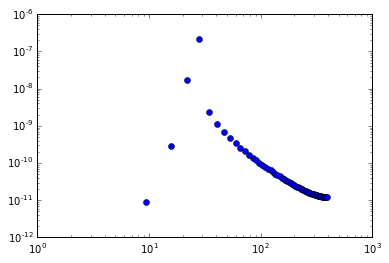

In [147]:
plt.loglog(kgridG,a1,'bo',label='slow')
#plt.loglog(kgridG,b1,'yo',label='fast')
print a1
print b1
#print kgridG/(2.*np.pi)

In [139]:
xg1=np.array([[1.,2.],[3.,4.]])
xg2 = np.array([[3.,8.],[2.,9.]])
print xg1
print xg2
print xg1*xg2
#yg1=np.linspace(0.,1.,n)

[[ 1.  2.]
 [ 3.  4.]]
[[ 3.  8.]
 [ 2.  9.]]
[[  3.  16.]
 [  6.  36.]]
